## Курсовой проект

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

__ОПИСАНИЕ ДАТАСЕТА__


* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
#Подключаем библиотеки
import pandas as pd
import numpy as np

import catboost as catb
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAINING_DATASET_PATH = r'C:/Users/a.slivaev/Desktop/course_project/course_project_train.csv'
TEST_DATASET_PATH = r'C:/Users/a.slivaev/Desktop/course_project/course_project_test.csv'

__Обзор данных__

In [3]:
df_train = pd.read_csv(TRAINING_DATASET_PATH)
df_train_init = df_train.copy()
df_train.head(7)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0


__Обработка обучающего датасета__

In [4]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
#ищем пропуски в данных 

df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [8]:
#Функция нахождения процентного соотношения целостности данных
def missing_data(df: pd.DataFrame) -> pd.Series:
    feature_counts = df.count()
    object_counts = df.shape[0]
    
    calc_percent = (1 - feature_counts/object_counts) * 100
    
    feature_percent = round(calc_percent, 2)
    result = {i: f'{v}%' for i, v in feature_percent.items() if v != 0}
    
    return pd.Series(result)

In [9]:
missing_data(df = df_train)

Annual Income                   20.76%
Years in current job             4.95%
Months since last delinquent    54.41%
Bankruptcies                     0.19%
Credit Score                    20.76%
dtype: object

В некоторых фичах есть очень большие пропуски данных. Далее мы избавляемся от этих пропусков:

In [10]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()

In [11]:
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent']  = 0

In [12]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [13]:
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = df_train['Credit Score'].median()

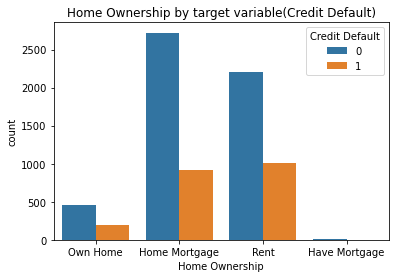

In [14]:
#посмотрим зависимость классов целевой переменной в Home Ownership
sns.countplot (x = 'Home Ownership', hue = 'Credit Default', data = df_train)
plt.title('Home Ownership by target variable(Credit Default)')
plt.show()

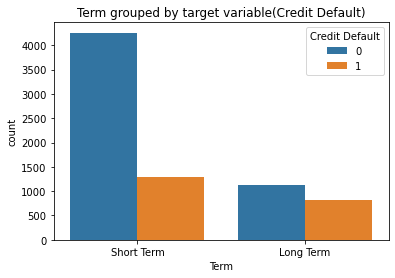

In [15]:
sns.countplot(x = 'Term', hue = 'Credit Default', data = df_train)
plt.title('Term grouped by target variable(Credit Default)')
plt.show()

In [16]:
#приведем некоторые переменные к виду дамми переменных для удобства анализа
for cat_colname in df_train.select_dtypes(include = 'object').columns:
    print(cat_colname)
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix = cat_colname)], axis = 1)
    df_train = df_train.drop(cat_colname, axis = 1)

Home Ownership
Years in current job
Purpose
Term


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   7500 non-null   float64
 1   Tax Liens                       7500 non-null   float64
 2   Number of Open Accounts         7500 non-null   float64
 3   Years of Credit History         7500 non-null   float64
 4   Maximum Open Credit             7500 non-null   float64
 5   Number of Credit Problems       7500 non-null   float64
 6   Months since last delinquent    7500 non-null   float64
 7   Bankruptcies                    7500 non-null   float64
 8   Current Loan Amount             7500 non-null   float64
 9   Current Credit Balance          7500 non-null   float64
 10  Monthly Debt                    7500 non-null   float64
 11  Credit Score                    7500 non-null   float64
 12  Credit Default                  75

__Обработка тестового датасета__

In [18]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test_init = df_test.copy()
df_test.head(7)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0


In [19]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [21]:
#ищем пропуски в данных

df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [22]:
missing_data(df = df_test)

Annual Income                   20.52%
Years in current job             3.44%
Months since last delinquent    54.32%
Bankruptcies                     0.12%
Credit Score                    20.52%
dtype: object

In [23]:
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].median()

In [24]:
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent']  = 0

In [25]:
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [26]:
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = df_test['Credit Score'].median()

In [27]:
#приведем некоторые переменные к виду дамми переменных для удобства анализа
for cat_colname in df_test.select_dtypes(include = 'object').columns:
    print(cat_colname)
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix = cat_colname)], axis = 1)
    df_test = df_test.drop(cat_colname, axis = 1)

Home Ownership
Years in current job
Purpose
Term


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Tax Liens                       2500 non-null   float64
 2   Number of Open Accounts         2500 non-null   float64
 3   Years of Credit History         2500 non-null   float64
 4   Maximum Open Credit             2500 non-null   float64
 5   Number of Credit Problems       2500 non-null   float64
 6   Months since last delinquent    2500 non-null   float64
 7   Bankruptcies                    2500 non-null   float64
 8   Current Loan Amount             2500 non-null   float64
 9   Current Credit Balance          2500 non-null   float64
 10  Monthly Debt                    2500 non-null   float64
 11  Credit Score                    2500 non-null   float64
 12  Home Ownership_Have Mortgage    25

In [29]:
df_test

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,...,0,0,0,0,0,0,0,0,0,1
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,...,0,0,0,0,0,0,0,0,0,1
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,...,0,0,0,0,0,0,0,0,0,1
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,...,0,0,0,0,0,0,0,0,0,1
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.0,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,99999999.0,162735.0,...,0,0,0,0,0,0,0,0,0,1
2496,1178475.0,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,468512.0,1439269.0,...,0,0,0,0,0,0,0,0,0,1
2497,1171806.0,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,430496.0,676438.0,...,0,0,0,0,0,0,0,0,0,1
2498,723520.0,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,257774.0,391248.0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
#добавляем переменную, которой нет в тестовой, но есть в тренировочной выборке(Purpose_renewable energy)

df_test.insert(loc=37, column = 'Purpose_renewable energy', value = 0)

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   2500 non-null   float64
 1   Tax Liens                       2500 non-null   float64
 2   Number of Open Accounts         2500 non-null   float64
 3   Years of Credit History         2500 non-null   float64
 4   Maximum Open Credit             2500 non-null   float64
 5   Number of Credit Problems       2500 non-null   float64
 6   Months since last delinquent    2500 non-null   float64
 7   Bankruptcies                    2500 non-null   float64
 8   Current Loan Amount             2500 non-null   float64
 9   Current Credit Balance          2500 non-null   float64
 10  Monthly Debt                    2500 non-null   float64
 11  Credit Score                    2500 non-null   float64
 12  Home Ownership_Have Mortgage    25

__Анализ данных__

In [32]:
target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()

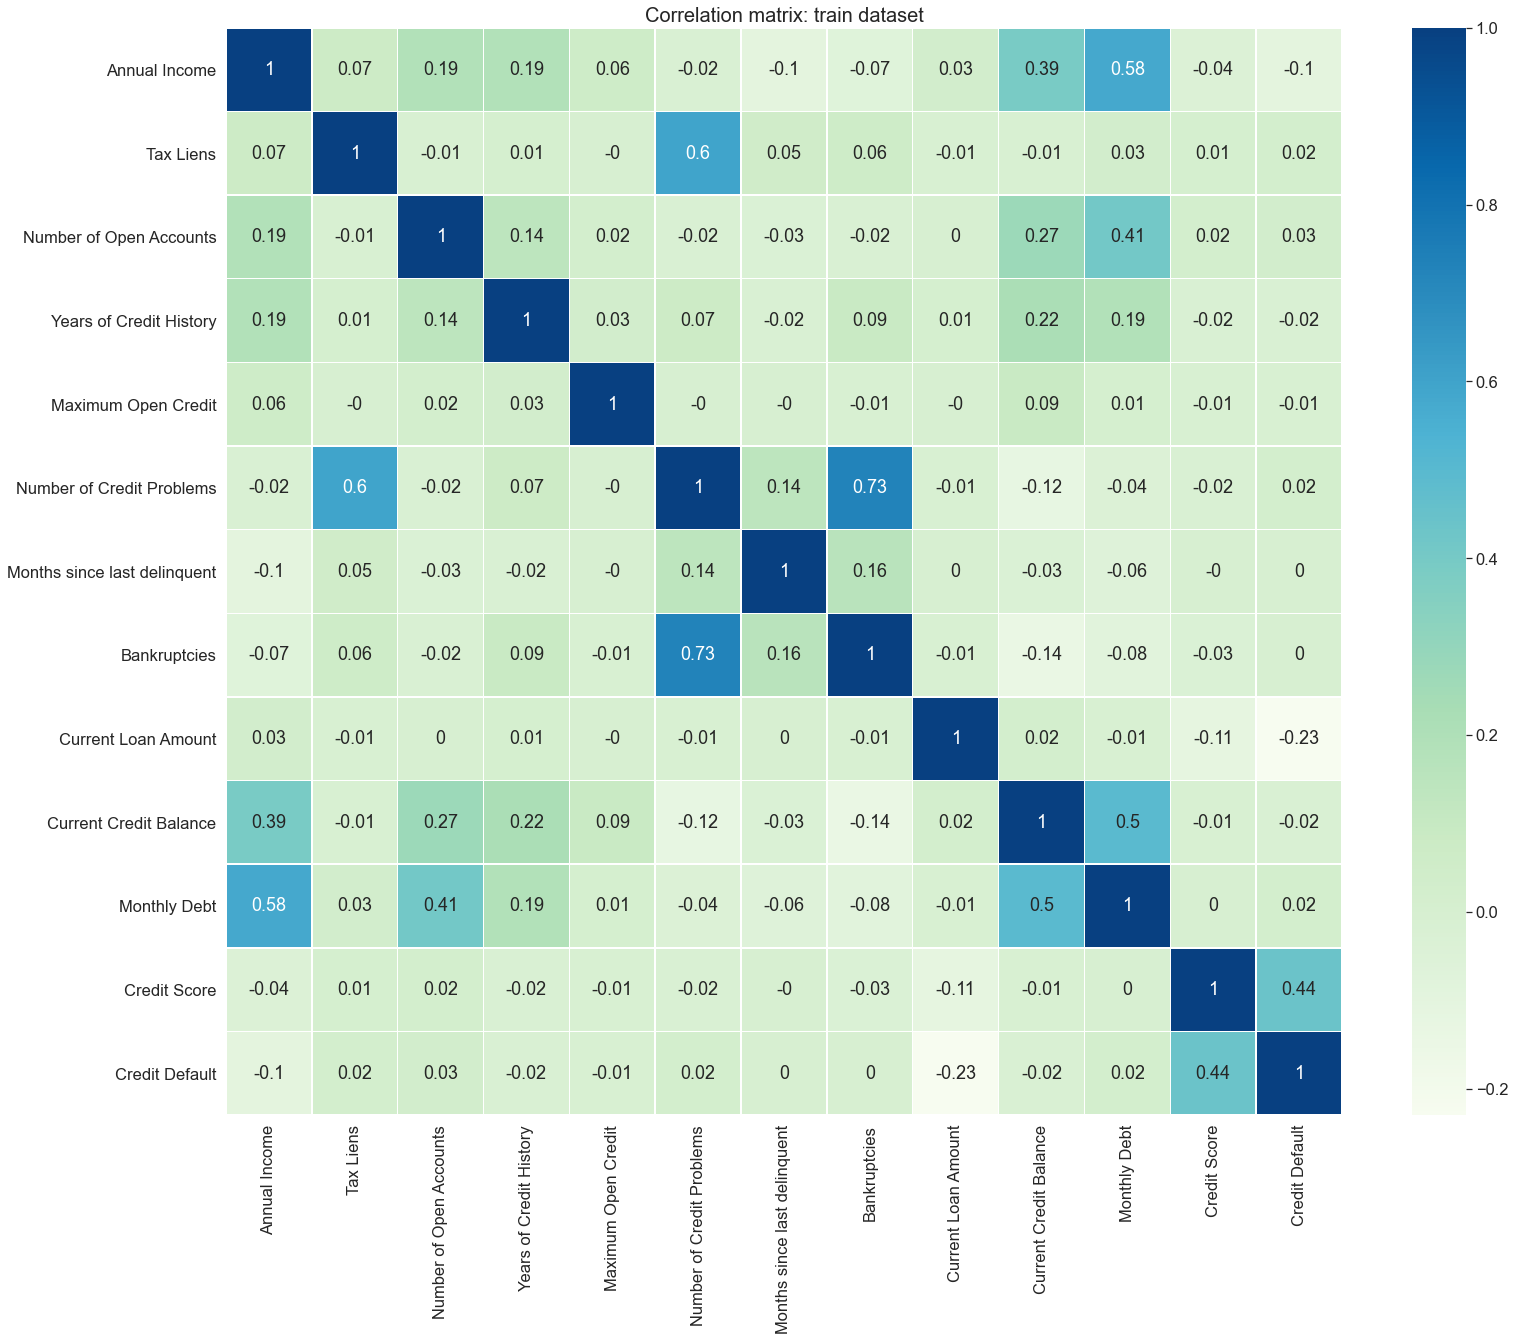

In [33]:
#матрица корреляций обучающего датасета 

plt.figure(figsize = (25,20))

sns.set(font_scale=1.5)
sns.heatmap(df_train_init.corr().round(2), annot=True, linewidths=.5, cmap='GnBu') #почитать про seaborn

plt.title('Correlation matrix: train dataset', fontsize = 20)
plt.show()

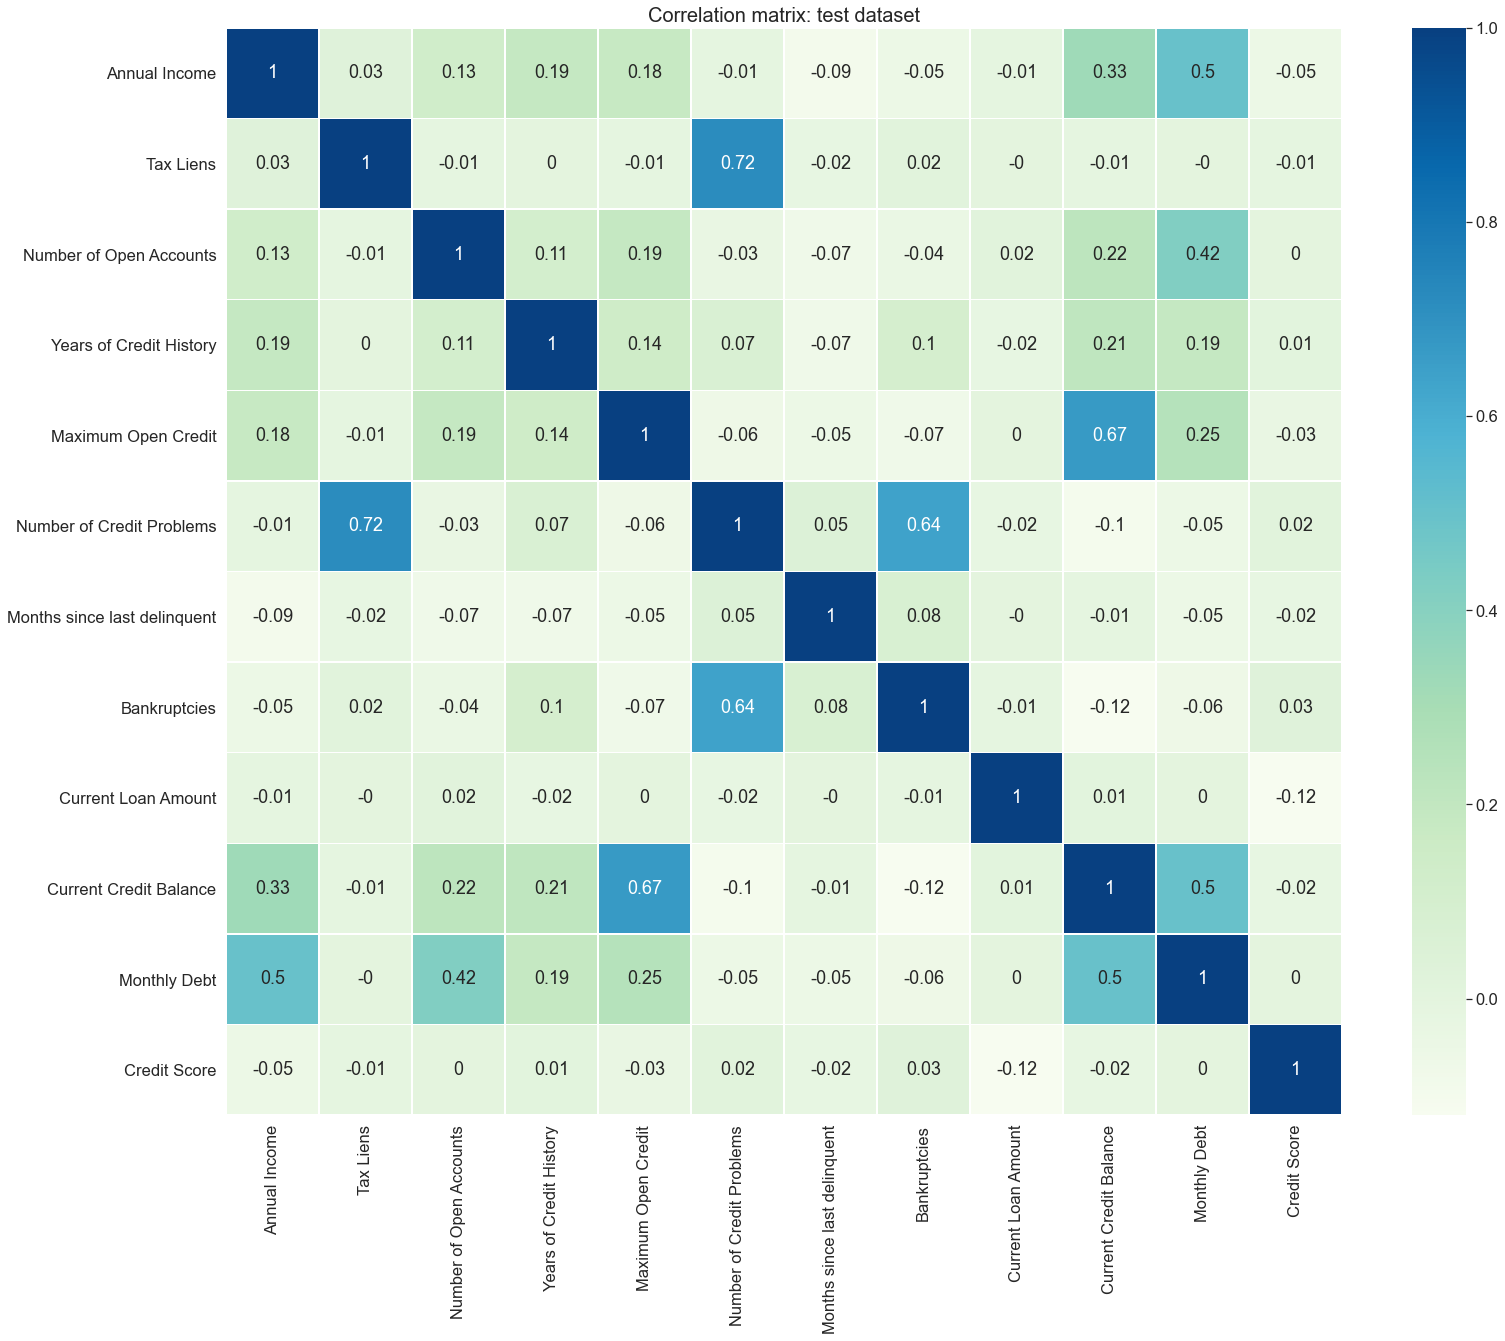

In [34]:
#матрица корреляций тестового датасета 

plt.figure(figsize = (25,20))

sns.set(font_scale=1.5)
sns.heatmap(df_test_init.corr().round(2), annot=True, linewidths=.5, cmap='GnBu') #почитать про seaborn

plt.title('Correlation matrix: test dataset', fontsize = 20)
plt.show()

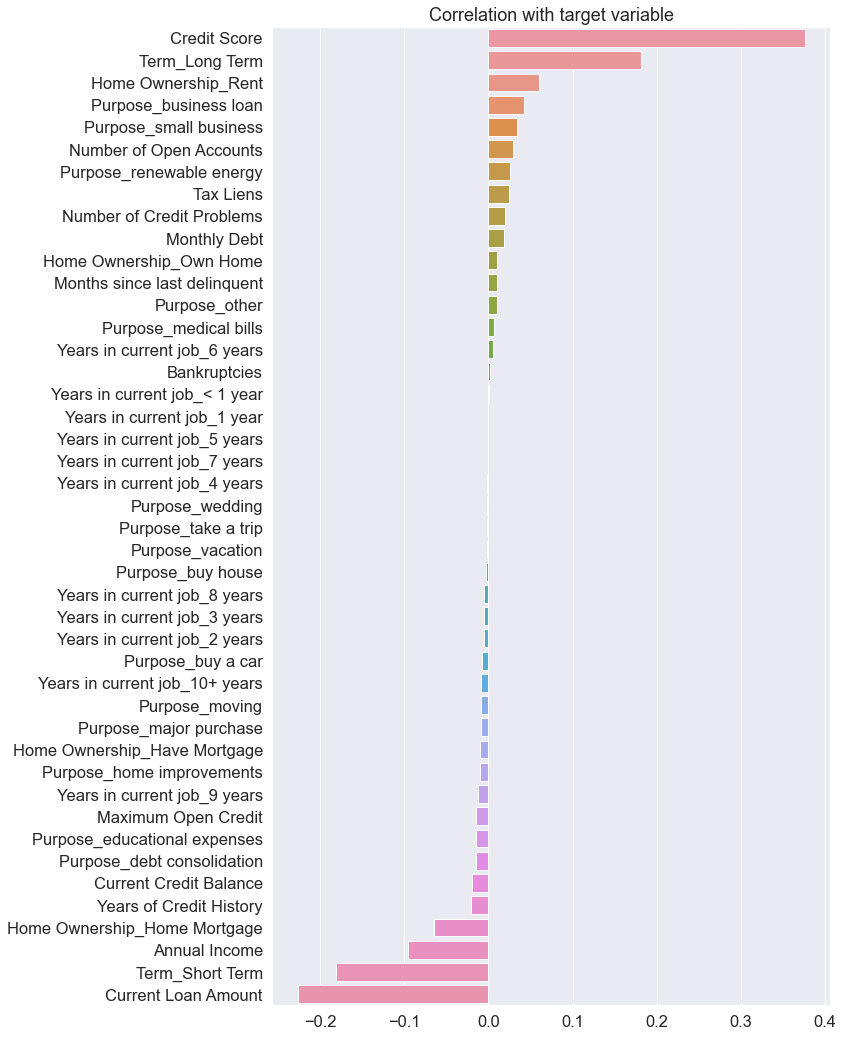

In [35]:
#корреляция с базовыми признаками 

corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 18))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

__Подготовка данных__

In [36]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [37]:
df_train[target_name].value_counts(normalize = True)

0   0.72
1   0.28
Name: Credit Default, dtype: float64

In [38]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [39]:
df_train_balanced = balance_df_by_target(df_train, target_name)

df_train_balanced[target_name].value_counts(normalize = True)

0   0.56
1   0.44
Name: Credit Default, dtype: float64

In [40]:
X = df_train_balanced[feature_names]
y = df_train_balanced[target_name]

____Обучение модели____

In [41]:
model = catb.CatBoostClassifier(silent = True, random_state = 21)

In [42]:
#подбор гиперпараметров
parameters = {'n_estimators' : [100, 500, 1000, 2000, 5000],
            'max_depth': [3, 5, 7, 10], 
            'l2_leaf_reg': [0.01, 0.1, 1, 10] }

In [43]:
rscv = RandomizedSearchCV(model, parameters, scoring ='f1', cv = KFold(n_splits = 3, random_state = 42, shuffle = True),
                         verbose = 4, n_jobs = -1)

In [44]:
#разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.3, random_state = 211)

In [45]:
scale = y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0] 

In [46]:
%%time
#обучение и оценка модели
final_model = catb.CatBoostClassifier(n_estimators = 10000, max_depth = 10, l2_leaf_reg = 0.1, scale_pos_weight = scale,
                                     silent=True, random_state=42)

final_model.fit(X_train, y_train)

Wall time: 5min 3s


In [47]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

In [48]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [49]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3776
           1       1.00      1.00      1.00      2953

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1611
           1       0.84      0.81      0.82      1273

    accuracy                           0.85      2884
   macro avg       0.84      0.84      0.84      2884
weighted avg       0.85      0.85      0.85      2884

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1414   197
1                248  1025


In [50]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (15, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

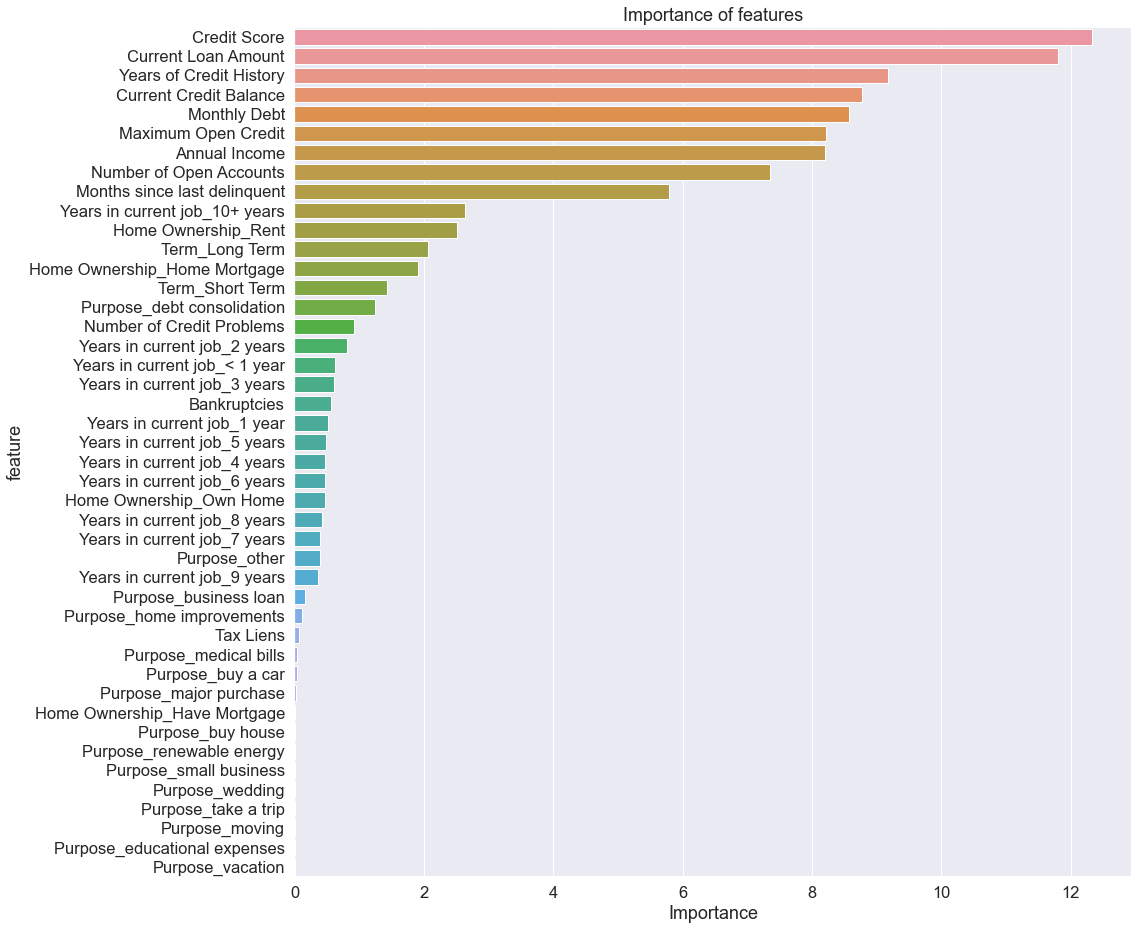

In [51]:
#важность признаков
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)


In [52]:
#выбор порога вероятности для определения класса

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.4, 0.4))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt.show()

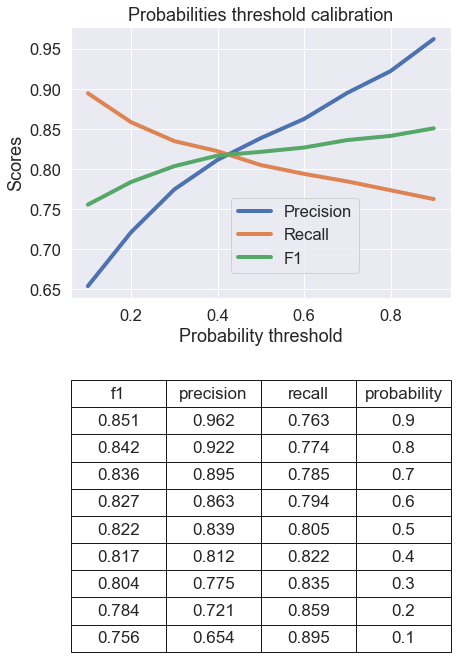

In [53]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Метрика f1 достигает максимума при пороге вероятность 0.9, с учётом ограничений precision > 0.5, recall > 0.5

In [54]:
threshold = 0.9

In [55]:
y_test_pred_probs.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
y_test_final_pred = y_test_pred_probs[:, 1].copy()

y_test_final_pred[y_test_final_pred >= threshold] = 1
y_test_final_pred[y_test_final_pred < threshold] = 0

In [57]:
sum(y_test_pred != y_test_final_pred)

213

In [58]:
get_classification_report(y_train, y_train_pred, y_test, y_test_final_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3776
           1       1.00      1.00      1.00      2953

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1611
           1       0.96      0.76      0.85      1273

    accuracy                           0.88      2884
   macro avg       0.90      0.87      0.88      2884
weighted avg       0.89      0.88      0.88      2884

CONFUSION MATRIX

col_0           0.00  1.00
Credit Default            
0               1573    38
1                302   971


__Прогнозирование на тестовом датасете__

In [59]:
df_test_pred = final_model.predict(df_test)
df_test_pred_probs = final_model.predict_proba(df_test)

In [60]:
df_test_final_pred = df_test_pred_probs[:, 1].copy()

df_test_final_pred[df_test_final_pred > threshold] = 1
df_test_final_pred[df_test_final_pred <= threshold] = 0

In [61]:
sum(df_test_pred != df_test_final_pred)

253

In [62]:
result = pd.DataFrame(df_test_final_pred)

result.shape

(2500, 1)

__Сохранение результатов__

In [63]:
result.to_csv('AVSlivaev_predictions.csv', header = None, index = None)

In [64]:
pd.read_csv('AVSlivaev_predictions.csv').head()

,0.0
0,0.00
1,1.00
2,0.00
3,0.00
4,0.00
